In [2]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest

In [3]:
data = pd.read_excel('C:/Personal/09142640/Downloads/Crimes_new_york_by_city_2013.xls', sheet_name=0, header=4)
data.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


In [4]:
data = data.drop(data[data.Population > 15000].index)

In [5]:
regr = linear_model.LinearRegression()

features=data[['Population','Burglary','Larceny-theft','Motor vehicle theft','Property crime']].dropna()
Y = data[['Property crime']]
X = data[['Burglary','Larceny-theft','Motor vehicle theft']]
X=X.dropna()
Y=Y.dropna()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [6]:
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1. 1. 1.]]

Intercept: 
 [0.]

R-squared:
1.0


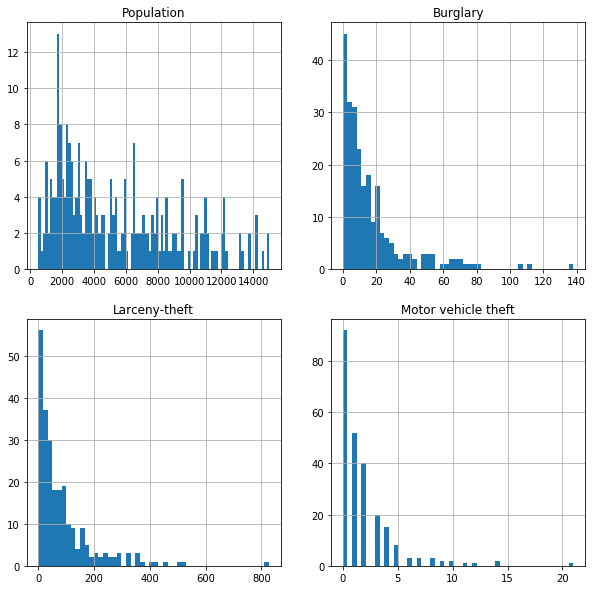

In [7]:
plt.figure(figsize=(10,10))
plt.subplot(221)
data['Population'].hist(bins=100)
plt.title('Population')

plt.subplot(222)
data['Burglary'].hist(bins=50)
plt.title('Burglary')

plt.subplot(223)
data['Larceny-theft'].hist(bins=50)
plt.title('Larceny-theft')

plt.subplot(224)
data['Motor vehicle theft'].hist(bins=50)
plt.title('Motor vehicle theft')


plt.show()

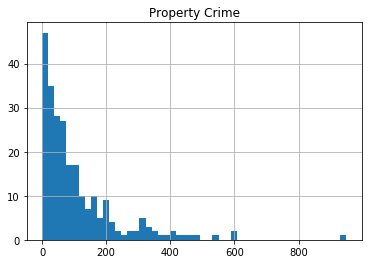

In [8]:
data['Property crime'].hist(bins=50)
plt.title('Property Crime')
plt.show()

# Assumption one: linear relationship

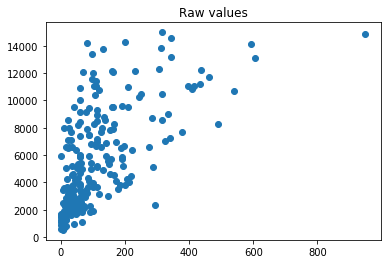

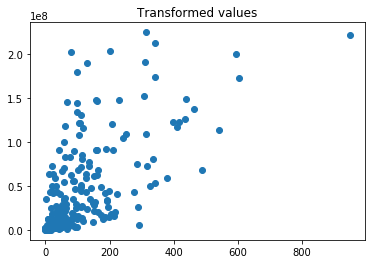

In [9]:
data['Sq_population']=data['Population']*data['Population']
plt.scatter(data['Property crime'], data['Population'])
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation.
#sqrt_feature = [math.sqrt(x) for x in  feature]


# Well now isn't that nice.
plt.scatter(data['Property crime'], data['Sq_population'])
plt.title('Transformed values')
plt.show()

# Assumption two: multivariate normality


In [10]:
predicted = regr.predict(X).ravel()
actual = data['Property crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

ValueError: operands could not be broadcast together with shapes (248,) (245,) 

# Assumption three: homoscedasticity

In [ ]:
#plt.scatter(predicted, residual)
#plt.xlabel('Predicted')
#plt.ylabel('Residual')
#plt.axhline(y=0)
#plt.title('Residual vs. Predicted')
#plt.show()

In [11]:
correlation_matrix = X.corr()
display(correlation_matrix)

,Burglary,Larceny-theft,Motor vehicle theft
Burglary,1.000,0.777,0.548
Larceny-theft,0.777,1.000,0.542
Motor vehicle theft,0.548,0.542,1.000


# We will use PCA to check for the optimimum number of components


# PCA:

In [14]:
features_pca = data.loc[:, ['Population', 'Sq_population', 'Burglary','Larceny-theft','Motor vehicle theft','Property crime']].dropna()

In [16]:
# The NumPy covariance function assumes that variables are reprensented by rows, not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00409836 0.96939734 0.59806049 0.63695748 0.41136166 0.65149868]
 [0.96939734 1.00409836 0.59322944 0.64389874 0.39462482 0.65627548]
 [0.59806049 0.59322944 1.00409836 0.78027581 0.55039959 0.8436052 ]
 [0.63695748 0.64389874 0.78027581 1.00409836 0.54439048 0.99811237]
 [0.41136166 0.39462482 0.55039959 0.54439048 1.00409836 0.57747657]
 [0.65149868 0.65627548 0.8436052  0.99811237 0.57747657 1.00409836]]


In [17]:
X = StandardScaler().fit_transform(features_pca)
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

In [18]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(60 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[0.40492968]
 [0.40444026]
 [0.4156498 ]
 [0.44102251]
 [0.31754769]
 [0.4520596 ]]
Eigenvalue 1: 4.329867954588378
------------------------------------------------------------
Eigenvector 2: 
[[ 0.54743623]
 [ 0.55583582]
 [-0.23384311]
 [-0.20586522]
 [-0.49359797]
 [-0.22507347]]
Eigenvalue 2: 0.8546082596035945
------------------------------------------------------------
Eigenvector 3: 
[[ 0.19449993]
 [ 0.162801  ]
 [-0.23504073]
 [-0.35456442]
 [ 0.80603646]
 [-0.32405366]]
Eigenvalue 3: 0.550935135655938
------------------------------------------------------------
Eigenvector 4: 
[[ 0.7057711 ]
 [-0.70766462]
 [-0.01613119]
 [ 0.01773688]
 [-0.01941265]
 [ 0.01209443]]
Eigenvalue 4: 0.03428803283127248
------------------------------------------------------------
Eigenvector 5: 
[[-0.02006128]
 [ 0.01346255]
 [-0.83771251]
 [ 0.47058034]
 [ 0.07199054]
 [ 0.26650621]]
Eigenvalue 5: 0.25489078125524944
------------------------------------------------------------
E

We keep components with an Eigenvalue > 1, that is Eigenvectors 1 and 6

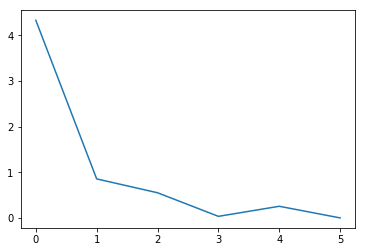

In [19]:
plt.plot(eig_val_cov)
plt.show()

As per the plot above,we should keep only the first component

In [20]:
# Instantiate our model.# Instan 
regr = linear_model.LinearRegression()
Y = data['Property crime'].dropna()
X = data[['Population', 'Sq_population']].dropna()

# Fit our model to our data.
regr.fit(X, Y)

# Display the attributes we calculated.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared: \n')
print(regr.score(X, Y))


Coefficients: 
 [9.02434077e-03 9.77581766e-07]

Intercept: 
 16.551192925602976

R-squared: 

0.4318694302207841


Using the variables as above that we used in PCA, R-square is 41%.That means that with the two features population, sq_population there was 41% variance in property crime